In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import animation, rc
from matplotlib.widgets import Slider, Button, RadioButtons
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import cm
import matplotlib


In [2]:
domain_definition = (-0., np.pi)

# Function

In [3]:
def f(xx, yy):
    z = (np.sin(xx*3)*np.cos(yy*3)+1)*((xx-np.pi/2)**2+(yy-np.pi/2)**2)/2
    return z

def gradf(xx, yy):
    
    dx = np.cos(xx*3)*3*np.cos(yy*3)*((xx-np.pi/2)**2+(yy-np.pi/2)**2)/2 + (np.sin(xx*3)*np.cos(yy*3)+1)*(xx-np.pi/2)
    dy = -np.sin(yy*3)*3*np.sin(xx*3)*((xx-np.pi/2)**2+(yy-np.pi/2)**2)/2 + (np.sin(xx*3)*np.cos(yy*3)+1)*(yy-np.pi/2)
    return np.asarray((dx, dy))

# Optimizer

In [4]:
def adam(grad, u, iteration, **kwargs):
    B_1 = kwargs['B1']
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']
    lr = kwargs['initial_lr']/np.sqrt(iteration)
    
    m_b = B_1*u['m_b']+(1-B_1)*grad
    v_b = B_2*u['v_b']+(1-B_2)*(grad**2)
    m_unb = u['m_b']/(1-(B_1**iteration))
    v_unb = u['v_b']/(1-(B_2**iteration))
    u['m_b'] = m_b
    u['v_b'] = v_b
    return -(lr*m_unb)/(np.sqrt(v_unb)+epsilon)

def sgd(grad, u, iteration, **kwargs):
    lr = kwargs['initial_lr']/np.sqrt(iteration)
    return -lr*grad

def adamax(grad, u, iteration, **kwargs):
    B_1 = kwargs['B1']
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']
    lr = kwargs['initial_lr']/math.sqrt(iteration)

    m_b = B_1*u['m_b']+(1-B_1)*grad
    
    v_b = np.maximum(grad**2, B_2*u['v_b'])
    m_unb = u['m_b']/(1-B_1**iteration)
    u['m_b'] = m_b
    u['v_b'] = v_b
    return -(lr*m_unb)/(np.sqrt(v_b)+epsilon)

def adagrad(grad, u, iteration, **kwargs):
    lr = kwargs['initial_lr']/math.sqrt(iteration)
    epsilon = kwargs['epsilon']
    v_b = u['v_b']
    u['v_b'] += grad**2
    return -(lr*grad)/(np.sqrt(v_b)+epsilon)

def RMSprop(grad, u, iteration, **kwargs):
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']    
    lr = kwargs['initial_lr']/math.sqrt(iteration)
    v_b = B_2*u['v_b']+(1-B_2)*(grad**2)
    u['v_b'] = v_b
    return -(lr*grad)/(np.sqrt(v_b)+epsilon)
    

def ams(grad, u, iteration, **kwargs):
    B_1 = kwargs['B1']
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']
    lr = kwargs['initial_lr']/math.sqrt(iteration)

    m_b = B_1*u['m_b']+(1-B_1)*grad
    v_b = B_2*u['v_b']+(1-B_2)*(grad**2)
    m_unb = u['m_b']/(1-B_1**iteration)
    v_unb = u['v_b']/(1-B_2**iteration)
    u['m_b'] = m_b
    u['v_b'] = v_b
    v_unb = np.maximum(u['v_unb'], v_b)
    u['v_unb'] = v_unb
    return -(lr*m_unb)/(np.sqrt(v_unb)+epsilon)

# Display

<IPython.core.display.Javascript object>


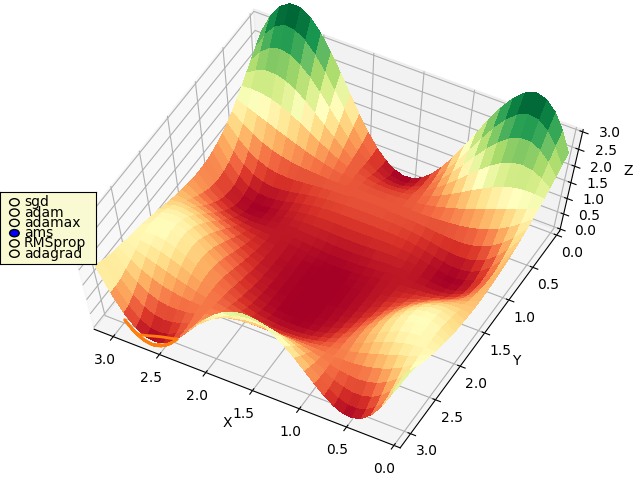

<IPython.core.display.Javascript object>


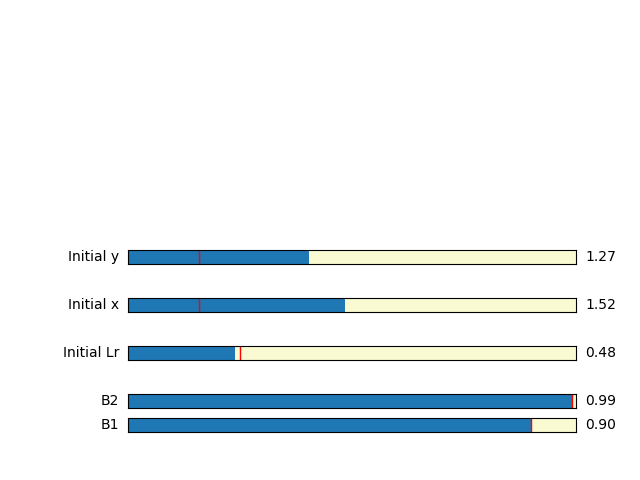

0

In [5]:
hyperparams = dict(B1 = 0.9, B2 = 0.99, epsilon = 1e-8, initial_lr=.05, init_x = .5, init_y = .5)
optimizer = dict(default=sgd)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.set_xlim3d(domain_definition)
ax.set_ylim3d(domain_definition)
ax.set_zlim3d([.0, 3.0])

ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_zlabel('Z')


MAX_SEGMENT = 50
MAX_ITER = 75
axcolor = 'lightgoldenrodyellow'


x = np.arange(*domain_definition, 0.1)
y = np.arange(*domain_definition, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
ax.plot_surface(xx,yy,f(xx, yy), shade=True, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap=cm.RdYlGn)
line, = ax.plot([], [], [], lw=2)

axRadio = plt.axes([0.0, 0.45, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(axRadio, ('sgd', 'adam', 'adamax', 'ams', 'RMSprop', 'adagrad'))
def optimFunc(label):
    optimdict = {'sgd':sgd, 'adam':adam, 'adamax':adamax, 'ams':ams, 'adagrad': adagrad, 'RMSprop': RMSprop}
    optimizer['default'] = optimdict[label] 
radio.on_clicked(optimFunc)

def train_gen():
    params_x = [hyperparams['init_x']]
    params_y = [hyperparams['init_y']]
    losses = [f(params_x[0], params_y[0])]
    momentum = {'m_b':np.zeros((2,)), 'v_b':np.zeros((2,)), 'v_unb':np.zeros((2,))}
    cnt = 0
    while cnt < MAX_ITER:
        cnt += 1
        previous_x = params_x[-1] 
        previous_y = params_y[-1] 

        previous_loss = losses[-1]
        optim = optimizer['default']
        step_x, step_y = optim(gradf(previous_x, previous_y), momentum, cnt, **hyperparams)
        x = np.clip(previous_x + step_x, domain_definition[0], domain_definition[1])
        y = np.clip(previous_y + step_y, domain_definition[0], domain_definition[1])
        
        loss = f(x, y)
        params_x.append(x)
        params_y.append(y)

        losses.append(loss)
        if cnt > MAX_SEGMENT:
            del params_x[:-MAX_SEGMENT]
            del params_y[:-MAX_SEGMENT]
            del losses[:-MAX_SEGMENT]

        yield params_x, params_y, losses

def animate(data):    
    x, y, loss = data
    line.set_data(x, y)
    line.set_3d_properties(loss)
    return (line,)

anim = animation.FuncAnimation(fig, animate, train_gen, repeat=True, interval=50, blit=False)

fig = plt.figure()


axb1 = plt.axes([0.20, 0.1, 0.7, 0.03], facecolor=axcolor)
axb2 = plt.axes([0.20, 0.15, 0.7, 0.03], facecolor=axcolor)
axlr = plt.axes([0.20, 0.25, 0.7, 0.03], facecolor=axcolor)
axinit_x = plt.axes([0.20, 0.35, 0.7, 0.03], facecolor=axcolor)
axinit_y = plt.axes([0.20, 0.45, 0.7, 0.03], facecolor=axcolor)

sb1 = Slider(axb1, 'B1', 0., 1.0, valinit=0.9)
sb2 = Slider(axb2, 'B2', 0., 1.0, valinit=0.99)
sblr = Slider(axlr, 'Initial Lr', 0., 2.0, valinit=0.5)
sbx = Slider(axinit_x, 'Initial x', domain_definition[0], domain_definition[1], valinit=0.5)
sbY = Slider(axinit_y, 'Initial y', domain_definition[0], domain_definition[1], valinit=0.5)

def update(val):
    hyperparams['B1'] = float(sb1.val)
    hyperparams['B2'] = float(sb2.val)
    hyperparams['initial_lr'] = float(sblr.val)
    hyperparams['init_x'] = float(sbx.val)
    

sb1.on_changed(update)
sb2.on_changed(update)
sblr.on_changed(update)
sbx.on_changed(update)
